<a href="https://colab.research.google.com/github/Sugi1999/Computational-Biology-Projects/blob/main/Cancer_Cell_Invasion_into_Bone_Marrow_as_an_Ecological_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Undergraduate Software Project
Karen Gaffney BIOEN 437

# Cancer Cell Invasion into Bone Marrow as an Ecological System
Model By: Kun-Wan Chen and Kenneth J 

Expanded On: Karen Gaffney



# Programming Preliminaries

## Imports

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import seaborn as sns
import scipy.stats as st
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator
try:
    import tellurium as te
except:
    !pip install -q tellurium
    import tellurium as te
try:
    import SBstoat
except:
    !pip install -q SBstoat
    import SBstoat


     |████████████████████████████████| 28.1 MB 2.9 MB/s 
     |████████████████████████████████| 292 kB 14.4 MB/s 
     |████████████████████████████████| 154 kB 29.1 MB/s 
     |████████████████████████████████| 98 kB 4.8 MB/s 


## Constants

In [ ]:
ENDTIME = 100
NUMPOINT = 1200
STDS = [0.1, 0.2, 0.5]
NUMFOLDS = [3, 5, 10]
# Column names
C_TIME = "time"
#

## BioModels 45

In [ ]:
MODEL_RR = te.loadSBMLModel("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000793.3?filename=Chen2011%3A1.xml")
MODEL_ARR = MODEL_RR.simulate()
MODEL_ANT = MODEL_RR.getAntimony()
print(MODEL_ANT)

// Created by libAntimony v2.12.0
function hg(b1, H)
  b1*H*(1 - H);
end

hg is "hg"

function tg(b2, T, H)
  b2*T*(1 - T - H);
end

tg is "tg"

function ti(b1, T, H)
  b1*T*H;
end

ti is "ti"


model *Chen2011_1___bone_marrow_invasion_absolute_model()

  // Compartments and Species:
  compartment bone_marrow;
  species H in bone_marrow, T in bone_marrow;

  // Reactions:
  HSC_growth:  => H; bone_marrow*hg(b1, H);
  HSC_death: H => ; bone_marrow*u1*H;
  Tumor_growth:  => T; bone_marrow*tg(b2, T, H);
  Tumor_death: T => ; bone_marrow*u2*T;
  Tumor_inhibition: T => ; bone_marrow*ti(b1, T, H);

  // Species initializations:
  H = 0.6;
  H has substance_per_volume;
  T = 0.0001;
  T has substance_per_volume;

  // Compartment initializations:
  bone_marrow = 1;
  bone_marrow has volume;

  // Variable initializations:
  b1 = 0.2;
  b1 has unit_0;
  u1 = 0.1;
  u1 has unit_0;
  b2 = 0.8;
  b2 has unit_0;
  u2 = 0.1;
  u2 has unit_0;

  // Other declarations:
  const bone_marrow, b1, u1, b2

In [ ]:
def arrToDF(arr):
    """
    Converts a NamedArray into a DataFrame.
    If it is simulation output, makes TIME the index.

    Parameters
    ----------
    arr: NamedArray
    
    Returns
    -------
    DataFrame
        Removes "[" , "]" from the names of species
    """
    columns = [c[1:-1] if c[0] == "[" else c for c in arr.colnames]
    df = pd.DataFrame(arr, columns=columns)
    df = df.set_index(C_TIME)
    return df

# Tests
assert(isinstance(arrToDF(MODEL_ARR), pd.DataFrame))
print("OK!")

OK!


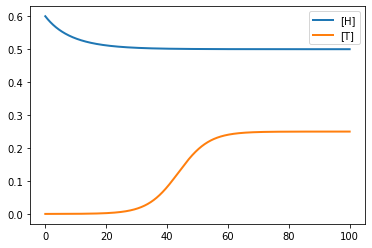

In [ ]:
# Values of model parameters in the model
MODEL_RR.reset()
MODEL_ARR = MODEL_RR.simulate(0, 100, 1200)
MODEL_RR.plot(MODEL_ARR)
MODEL_DF = arrToDF(MODEL_ARR)

## Helper Functions

In [ ]:
def foldGenerator(numPoint, numFold):
    """
    Generates pairs of trainining and test indices.
    
    Parameters:
    ----------
    numPoint: int
        number of time points
    numFold: int
        number of pairs of testIndices and trainIndices
    
    Returns:
    --------
    list of pairs of train indices, test indices
    """
    indices = range(numPoint)
    for remainder in range(numFold):
        testIndices = []
        for idx in indices:
            if idx % numFold == remainder:
                testIndices.append(idx)
        trainIndices = list(set(indices).difference(testIndices))
        yield trainIndices, testIndices
        
# Tests
numpoint = 6
numfold = 3
generator = foldGenerator(numpoint, numfold)
folds = list(generator)
assert(len(folds) == numfold)
for fold in folds:
    composite = list(fold[0])
    composite.extend(fold[1])
    assert(len(composite) == numpoint)
print("OK!")

OK!


In [ ]:
def findCloseMatchingValues(longArr, shortArr):
    """
    Finds the indices in longArr that are closest to the values in shortArr.

    Parameters
    ----------
    longArr: np.array
    shortArr: np.arry

    Returns
    -------
    array-int
    """
    indices = []
    for val in shortArr:
        distances = (longArr - val)**2
        minDistance = np.min(distances)
        distancesLst = list(distances)
        idx = distancesLst.index(minDistance)
        indices.append(idx)
    return np.array(indices)

# TESTS
longArr = np.array(range(10))
shortArr = np.array([2.1, 2.9, 4.3])
indexArr = findCloseMatchingValues(longArr, shortArr)
expectedArr = [2, 3, 4]
assert(all([v1 == v2 for v1, v2 in zip(indexArr, expectedArr)]))
print("OK!")


OK!


In [ ]:
def makeSyntheticData(df, std):
    """
    Creates synthetic data by adding a normally distributed random variable with mean zero and the specified
    standard deviation.
    
    Parameters
    ----------
    df: DataFrame
    std: float
    
    Returns
    -------
    DataFrame with same index and column names as df
    """
    timeseries = SBstoat.NamedTimeseries(dataframe=df)
    synthesizer = SBstoat.ObservationSynthesizerRandomErrors(fittedTS=timeseries, std=std)
    syntheticTS = synthesizer.calculate()
    df =  syntheticTS.to_dataframe()
    return df

#TESTS
observedDF = makeSyntheticData(MODEL_DF, 0)
assert(observedDF.equals(MODEL_DF))
print("OK!")

OK!


In [ ]:
def fitModel(model, observedDF, parameterNames, testIdxs):
    """
    Fits the model parameters to the observed data.
    
    Parameters
    ----------
    model: str
        Antimony model or roadrunner
    observedDF: DataFrame
        Index: time
        Columns: floating species
    parameterNames: list-str
    testIdxs: list-int
        Indices in data that should be ignored in fitting since
        they will be used to evaluate test data
    
    Returns
    -------
    parameterDct
        key: parameterName
        value: parameterEstimate
    DataFrame - fitted values
        key: time
        columns: floating species     
    """
    indexArr = np.array(observedDF.index)
    endTime = max(observedDF.index)
    testIndices = indexArr[testIdxs]  # Elements in index that are test data
    newObservedDF = observedDF.copy()
    newObservedDF.loc[testIndices, :] = np.nan
    newObservedDF.index.name = C_TIME
    observedTS = SBstoat.NamedTimeseries(dataframe=newObservedDF)
    fitter = SBstoat.ModelFitter(model, observedTS,
                          parameterNames,
                          endTime=endTime,
                          numPoint=len(observedDF))
    fitter.fitModel()
    parameterDct = dict(fitter.params.valuesdict())
    #
    return parameterDct, fitter.fittedTS.to_dataframe()

# Tests
observedDF = makeSyntheticData(MODEL_DF, 0)
observedDF = observedDF[observedDF.index < 5]
parameterDct, fittedDF = fitModel(MODEL_ANT, observedDF, ["H"], [10, 20])
assert(len(parameterDct) == 1)
#assert(np.abs(parameterDct["H"] - 1) < 0.001)
assert(len(observedDF) == len(fittedDF))
print("OK!")

OK!


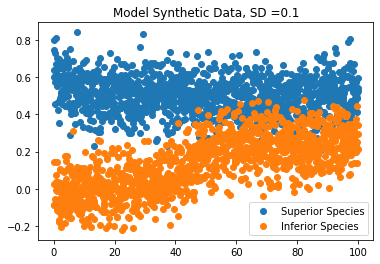

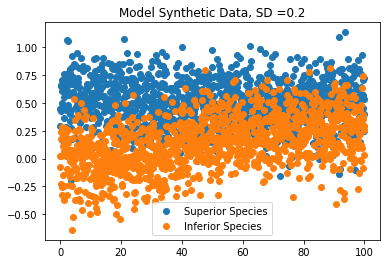

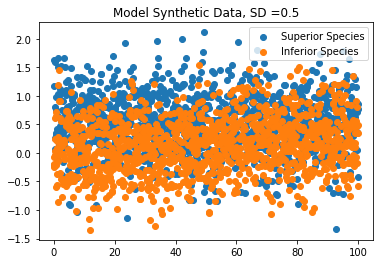

In [ ]:
def plot_sim(sd_n, labels):
  '''
  plots simulated data

  Parameters
  ----------
  sd_n - a list of simulated data sets
  labels - species labels

  Returns
  -------
  nothing
  '''
  for count, sd in enumerate(sd_n):
    plt.scatter(x, sd['H'])
    plt.scatter(x, sd['T'])
    plt.title('Model Synthetic Data, SD =' + labels[count])
    plt.legend(['Superior Species', 'Inferior Species'])
    plt.show()



x = np.linspace(0, ENDTIME, NUMPOINT)
sd_01 = makeSyntheticData(MODEL_DF, 0.1)
sd_02 = makeSyntheticData(MODEL_DF, 0.2)
sd_05 = makeSyntheticData(MODEL_DF, 0.5)
sd_n=[sd_01, sd_02, sd_05]
labels = ['0.1', '0.2', '0.5']
plot_sim(sd_n, labels)

In [ ]:
def calcRsq(fittedDF, testData, model=MODEL_RR):
  '''
  takes an estimated paramater value (from train), testdata, and model. 
  finds the rsq of the model

  Parameters
  ----------
  fittedDF - dataframe of fitted data
  testData - dataframe of test data
  model - antimony model loaded 

  Returns
  -------
  Rsq - rsquared value (float)

  '''
  indicies = findCloseMatchingValues(fittedDF.index, testData.index)
  indicies = [list(fittedDF.index)[x] for x in indicies]
  fittedDF=fittedDF.loc[indicies,:]
  columns = fittedDF.columns

  #calculating rsq
  fit_val = []
  test_val = []
  for col in columns:
    fit_val.extend(list(fittedDF.loc[:, col]))
    test_val.extend(list(testData.loc[:, col]))
  
  res = [t_val - f_val for t_val, f_val in zip(test_val, fit_val)]
  rsq = 1 - np.var(res) / np.var(test_val)
  return rsq
 



# TESTS
# inputs
model = MODEL_ANT
observedData = sd_01 #MODEL_DF
parameterNames = ['u1','u2','b1','b2']
folds = list(foldGenerator(NUMPOINT, 3))
testIndicies = folds[0][1]

#perform fit
parameterEstimates, fitDF = fitModel(model, observedData, parameterNames, testIndicies)
#calculate rsq
obTime = observedData.index
testIndicies = [obTime[x] for x in testIndicies]
testData = observedData.loc[testIndicies,:]
rsq = calcRsq(fitDF, testData)
assert(rsq>0)
print('OK!')

OK!



68.271916:     (Roadrunner exception: : CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double))

68.938616:     (Roadrunner exception: : CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double))


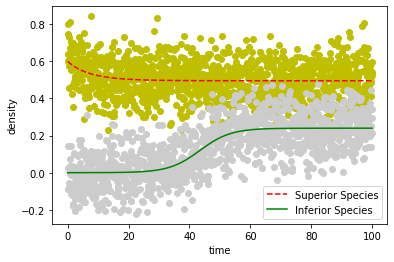

OK!


In [ ]:
def runExperiment(observedData, fold_n=[6,2], parameterNames=['u1','u2','b1','b2'], model=MODEL_ANT, label=None):
  '''
  fits model to experimental data with train/test folds

  Parameters
  ----------
  observedData - the experimental data we are fitting to
  fold_n - a list of train, test folds
  parameterNames - parameters to experiment with
  model - antimony string of model
  label - plot title

  Returns
  -------
  Rsq - rsq value of residual var and obs data variation
  parameterEstimates - best fit parameter values dictionary
  '''
  folds = list(foldGenerator(fold_n[0], fold_n[1]))
  testIndicies = folds[0][1]

  #perform fit
  parameterEstimates, fitDF = fitModel(model, observedData, parameterNames, testIndicies)
  
  columns = fitDF.columns
  x = np.linspace(0, ENDTIME, NUMPOINT)
 
  plt.scatter(x, observedData['H'], c="y")
  plt.plot(x, fitDF['H'], "r--")
  plt.scatter(x, observedData['T'], c="0.8")
  plt.plot(x, fitDF['T'], "g")

  plt.xlabel('time')
  plt.ylabel('density')
  plt.legend(['Superior Species','Inferior Species'])
  if labels is not None:
    plt.title(label)
  plt.show()

  #calculate rsq
  obTime = observedData.index
  testIndicies = [obTime[x] for x in testIndicies]
  testData = observedData.loc[testIndicies,:]
  rsq = calcRsq(fitDF, testData)
  return rsq, parameterEstimates

rsq, parameterEstimates = runExperiment(sd_01, fold_n=[NUMPOINT, 3])
assert(rsq>0)
assert(type(parameterEstimates) is dict)
print('OK!')

# Explanation of Model

This model simulates the invasion of cancer in to the bone marrow as an established eco system. This adapted Tilamn model of invasion dynamics defines cancer cells as the inferior species as they must grow in to the niches left behind by Hematopoetic Stem Cells (HSCs) to grow. HSCs are the superior species as they can hold on to their volume in the bone marrow aginst cancer cells until they die. 


The parameters and species used are:

H Density of Superior Species (HSC)

T Density of Inferior Species (Cancer)

β1 Birth rate of Superior Species

μ1 Death rate of Superior Species

β2 Birth rate of Inferior Species

μ2 Death rate of Inferior Species

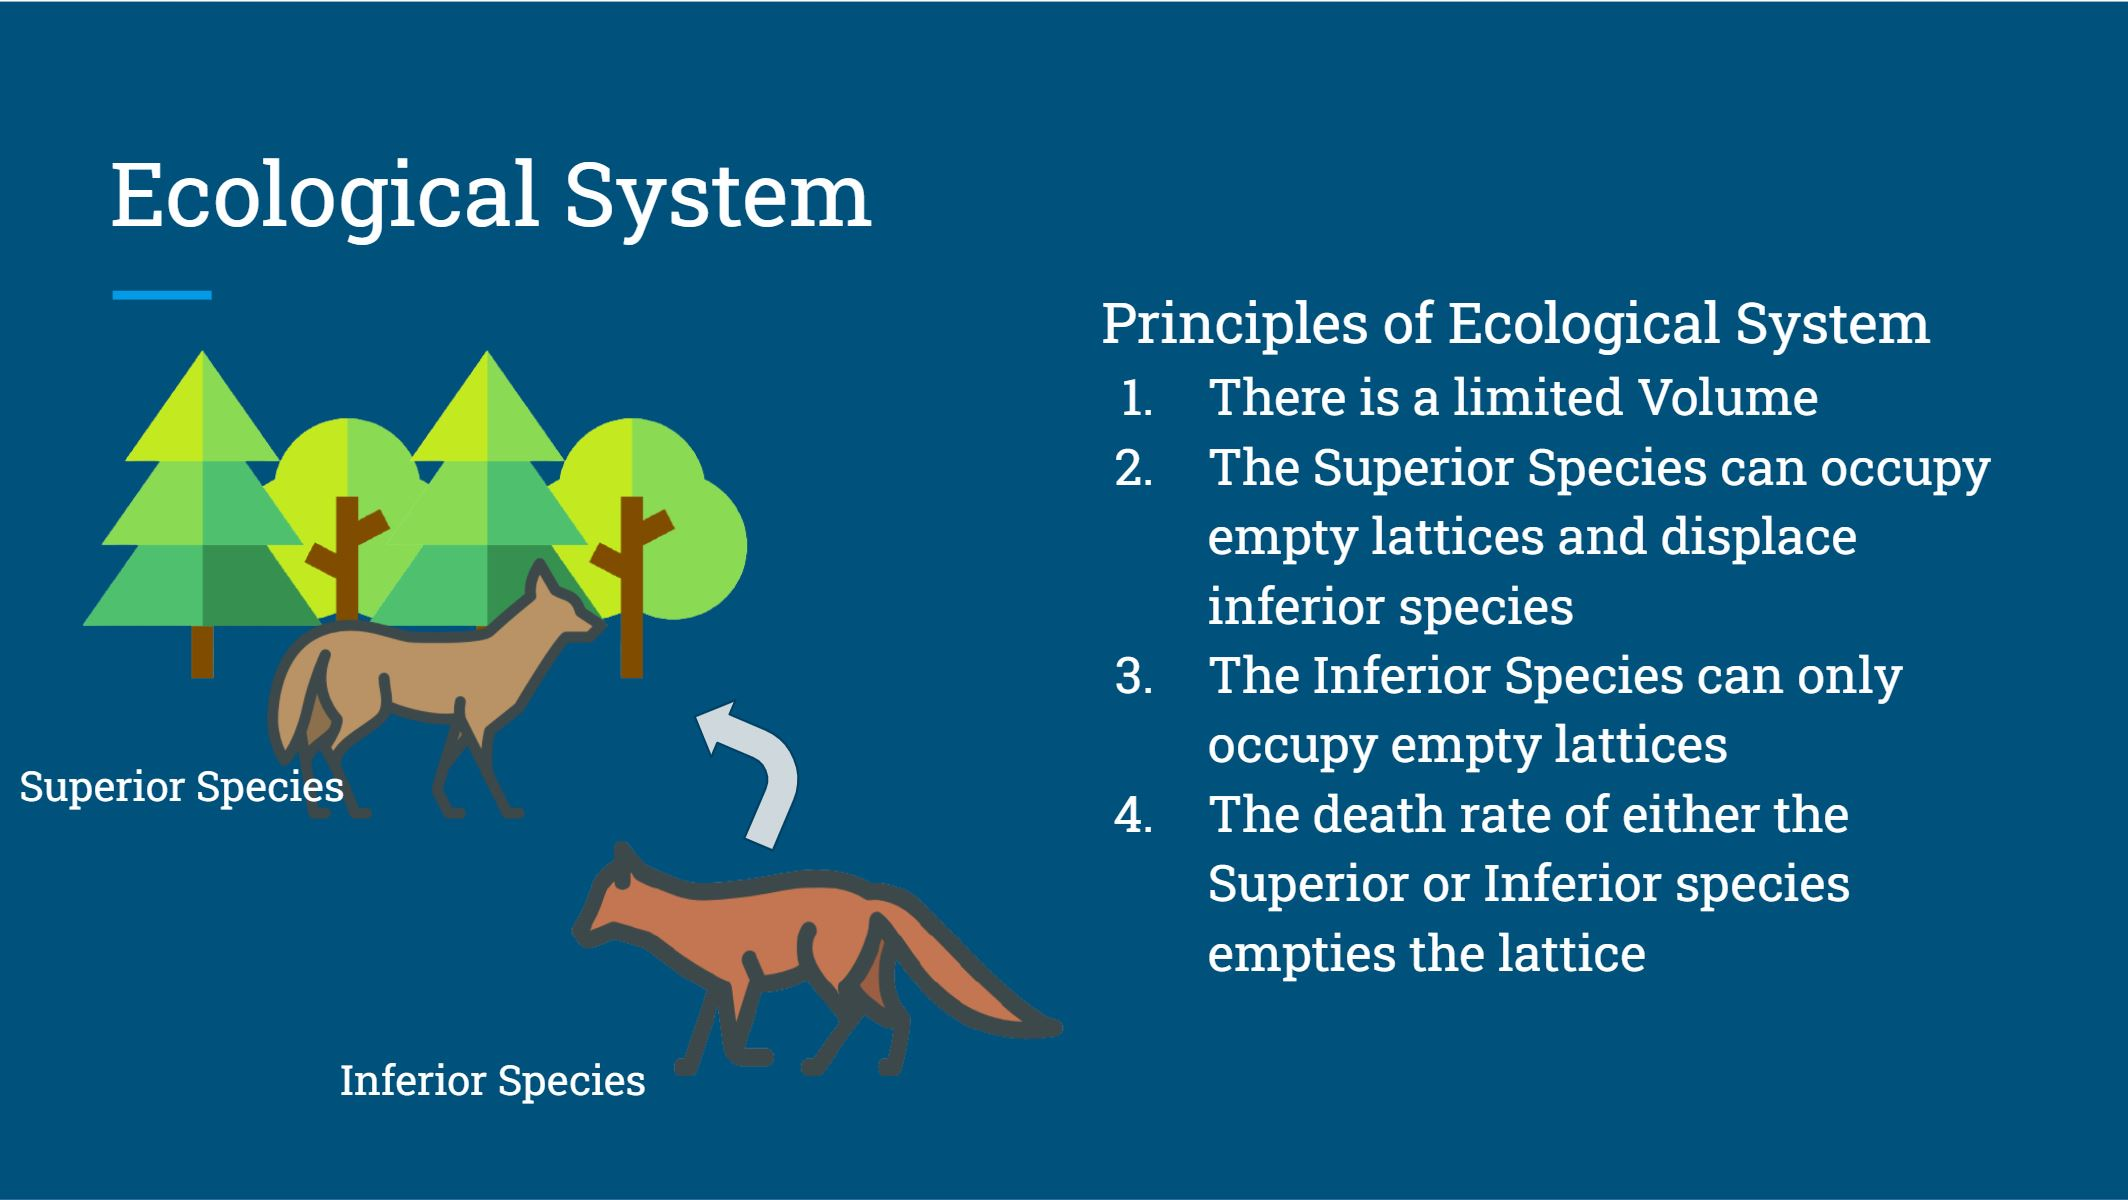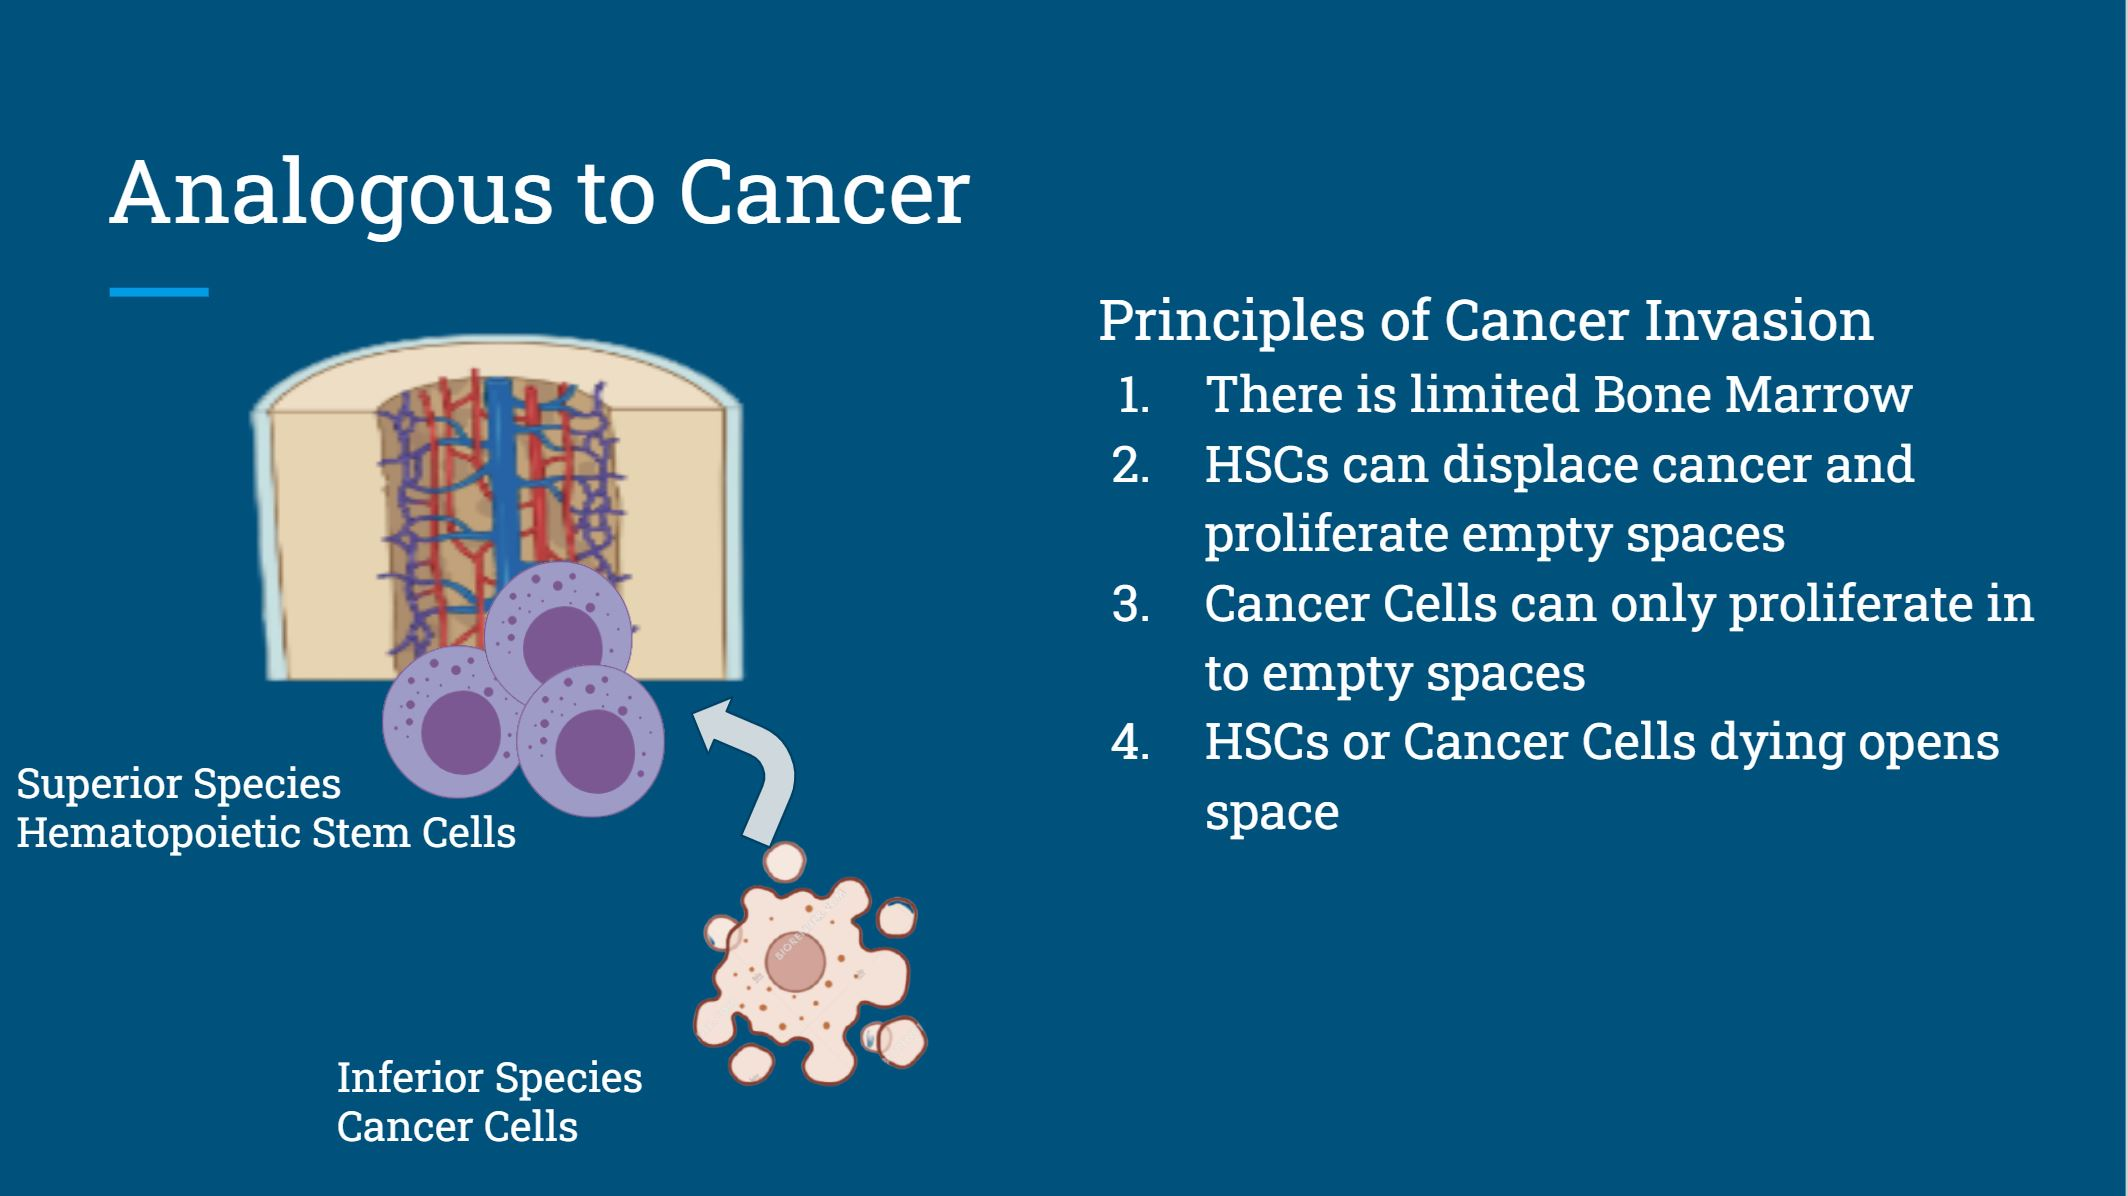

# Reanalysis

##Recreating Figure2

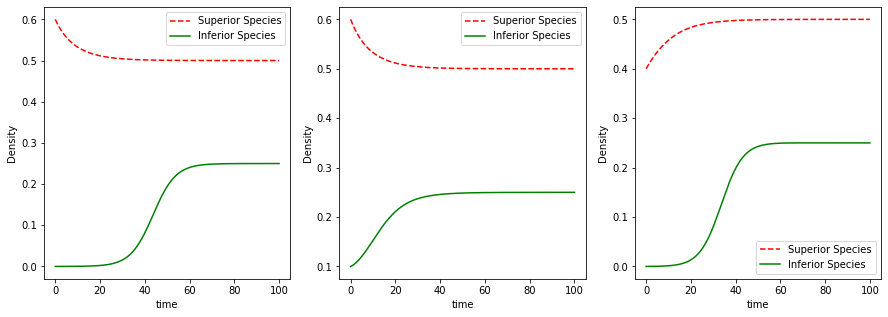

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, figsize=(15,5))
#base paramdct {'b1':0.2, 'u1': 0.1, 'b2':0.8, 'u2':0.1}
parameterDctList = [{'b1':0.2, 'u1': 0.1, 'b2':0.8, 'u2':0.1, 'H':0.6, 'T':0.0001},
                    {'b1':0.2, 'u1': 0.1, 'b2':0.8, 'u2':0.1, 'H':0.6, 'T':0.1},
                    {'b1':0.2, 'u1': 0.1, 'b2':0.8, 'u2':0.1, 'H':0.4, 'T':0.0001}]


for ax, parameterDct in zip((ax1, ax2, ax3), parameterDctList):
  MODEL_RR.resetAll()
  for key in parameterDct:
    MODEL_RR[key] = parameterDct[key]
  s = MODEL_RR.simulate(0, ENDTIME, NUMPOINT)

  ax.plot(s['time'], s['[H]'], "r--")
  ax.plot(s['time'], s['[T]'], "g")
  ax.legend(['Superior Species', 'Inferior Species'])
  ax.set_ylabel('Density')
  ax.set_xlabel('time')
  
  

Comparison of recreated figures (above) and figures from paper (below)

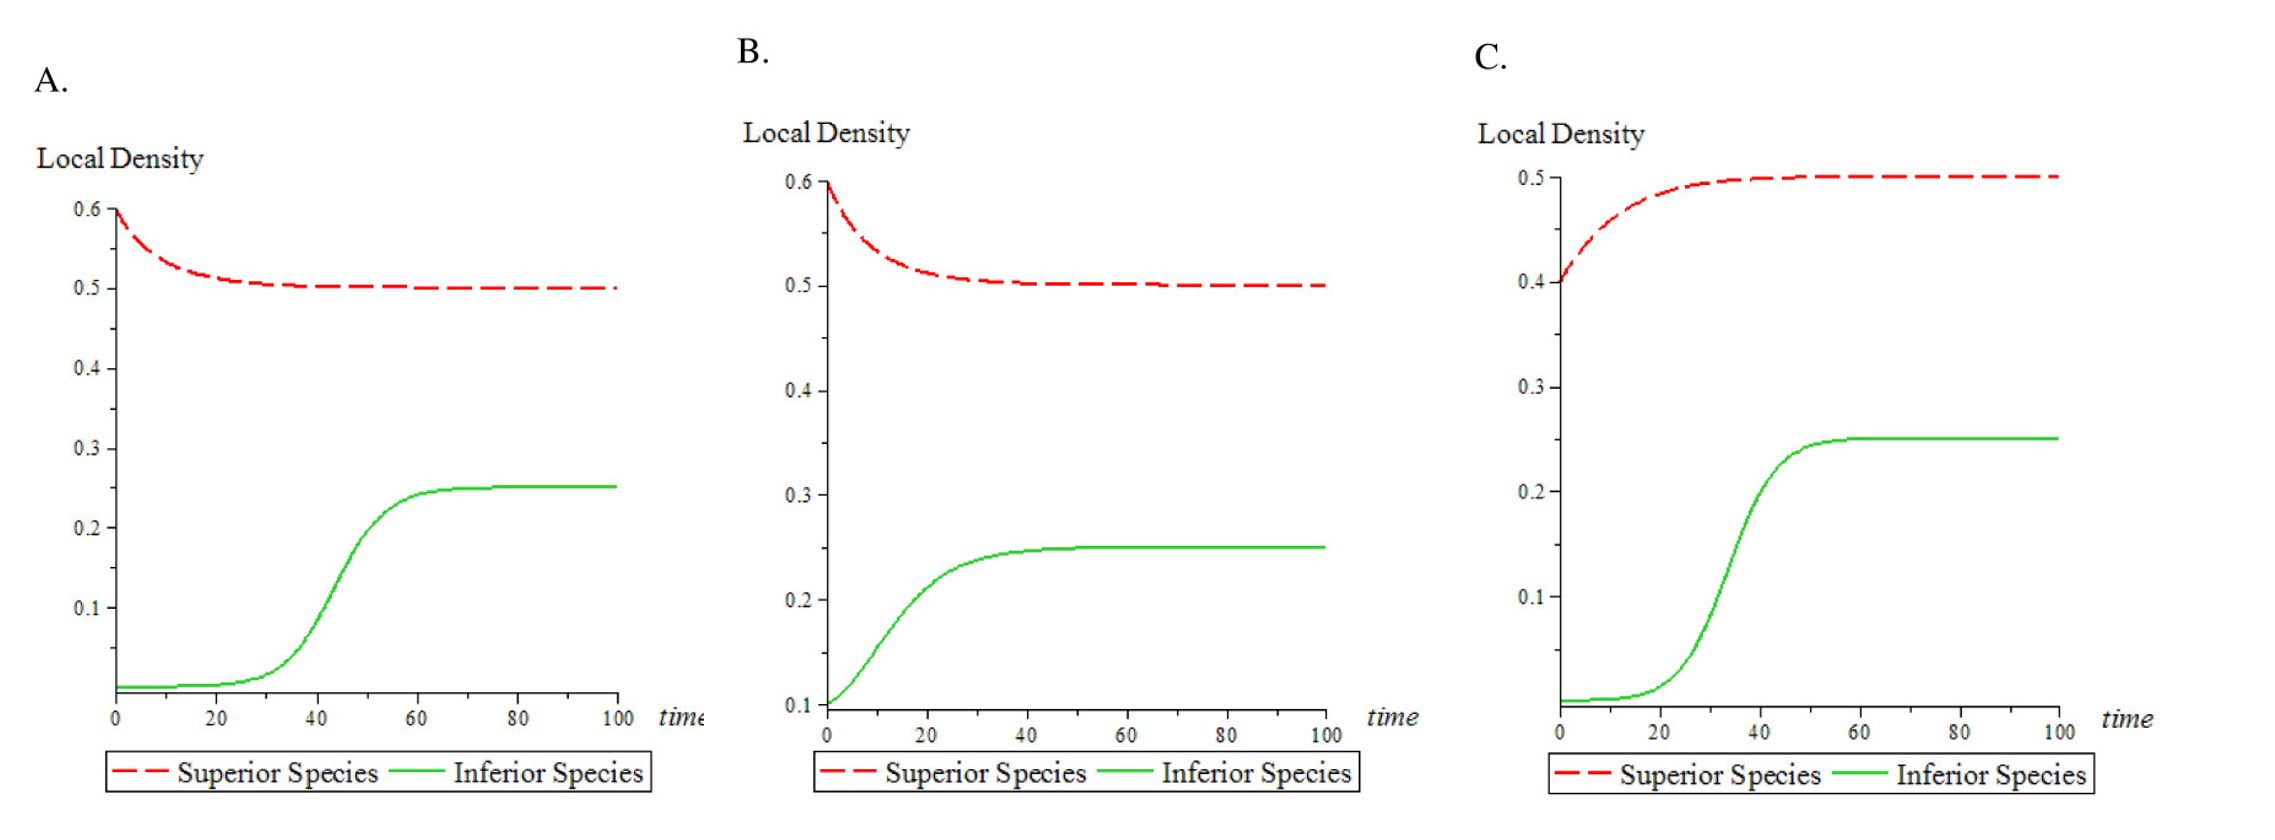

Caption from Paper

Figure 2. Competition among two species: HSCs as the superior species. The red (dash) line indicates the superior species (HSC); the green (solid) line indicates the inferior species (cancer cells). (A) superior species (HSC) has colonization rate β1 = 0.2, mortality rate μ1 = 0.1 time-1, and initial density = 0.6. The inferior species (cancer cells) has a colonization rate of β2 = 0.8, mortality rate μ2 = 0.1 time-1, and initial density = 0.0001. (B) The inferior species (cancer cells) has an initial density = 0.1; all other conditions remained the same as in (A). (C) Superior species (HSC) has an initial density = 0.4; all other conditions remained the same as in (A).

##Checking model robustness with Rsq

In [ ]:
#1.1
#Create 3 sets of synthetic data for standard deviations of 0.1, 0.2, and 0.5.

sd_01 = makeSyntheticData(MODEL_DF, 0.1)
sd_02 = makeSyntheticData(MODEL_DF, 0.2)
sd_05 = makeSyntheticData(MODEL_DF, 0.5)


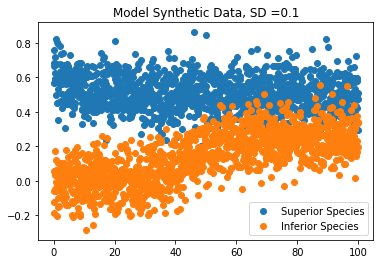

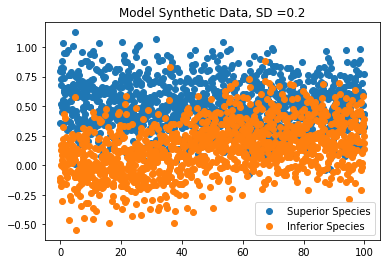

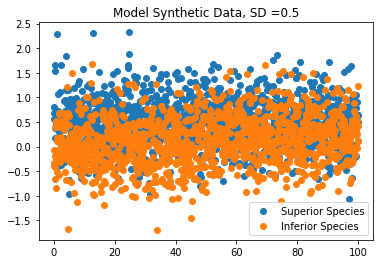

In [ ]:
# Plot Synthetic Data
x = np.linspace(0, ENDTIME, NUMPOINT)
sd_n=[sd_01, sd_02, sd_05]
labels = ['0.1', '0.2', '0.5']
plot_sim(sd_n, labels)


124.384685:     (Roadrunner exception: : CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double))


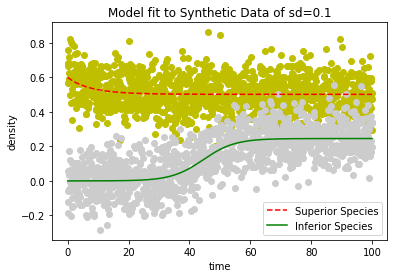

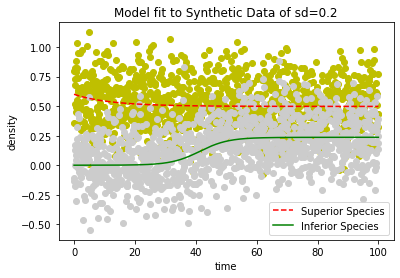

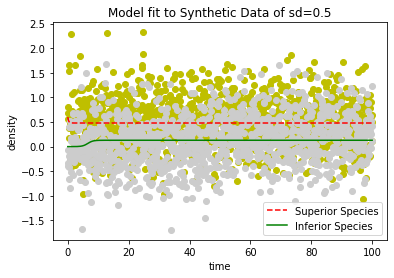

Rsq and Parameter Values across Synthetic Datasets


,rsq,b1,u1,b2,u2
actual,1.000000,0.200000,0.100000,0.800000,0.100000
sd=0.1,0.917634,0.231732,0.115398,0.784833,0.081562
sd=0.2,0.870219,0.143724,0.072233,0.934544,0.177252
sd=0.5,0.469847,6.563406,3.414831,9.065797,0.396386




Variation of Rsq and Parameters across Synthetic Datasets


,rsq,b1,u1,b2,u2
results,0.041734,7.612954,2.065637,12.690987,0.015653


In [ ]:
#looking at rsq and parameter variation across synthetic data

rsq_list = [1]
parameterList = []
labels = ['Model fit to Synthetic Data of sd=0.1', 'Model fit to Synthetic Data of sd=0.2', 'Model fit to Synthetic Data of sd=0.5']
for count, sd in enumerate(sd_n):
  rsq, parameterEstimates = runExperiment(sd, label=labels[count])
  rsq_list.append(rsq)
  parameterList.append(parameterEstimates)
#base paramdct {'b1':0.2, 'u1': 0.1, 'b2':0.8, 'u2':0.1}
b1 = [0.2]
u1 = [0.1]
b2 = [0.8]
u2 = [0.1]
for Dct in parameterList:
  b1.append(Dct['b1'])
  b2.append(Dct['b2'])
  u1.append(Dct['u1'])
  u2.append(Dct['u2'])

results = pd.DataFrame({'rsq': rsq_list, 'b1':b1, 'u1':u1, 'b2':b2, 'u2':u2}, index=['actual', 'sd=0.1', 'sd=0.2', 'sd=0.5'])
print("Rsq and Parameter Values across Synthetic Datasets")
display(results)
print('\n')
results2 = pd.DataFrame({'rsq': np.var(rsq_list), 'b1':np.var(b1), 'u1':np.var(u1), 'b2':np.var(b2), 'u2':np.var(u2)}, index=['results'])
print("Variation of Rsq and Parameters across Synthetic Datasets")
display(results2)

## Observations

I would assess this model to be robust. The model was able to attain a Rsq value of over 0.8 even with a synthetic data standard deviation of 0.2. At a standard deviation of 0.5, the model fell to an Rsq value of 0.066. However, this was fair as the data itself just looks like two blobs. 

I used three folds for my model fit evaluation as that had the best rsq, rsq variance based off my work in HW 4 Cross validation. 

# New Study Question

What are the combinatorial effects of u1, b1, u2, and b2 on the ratio of cancer cells (inferior species) to HSCs [Hematopoetic Stem Cells] (superior species) at the end of the simulation? 

#Computational Study

In [ ]:
def runStudy(parameterDct=None, roadrunner=MODEL_RR, NUMPOINT=NUMPOINT):
    """
    Runs a simulation for parameters with percentage changes from baseline values.

    Parameters
    ----------
    parameterDct: dict
       key: parameter
       value: float - value for parameter
    roadrunner: ExtendedRoadRunner
    ENDTIME: float
    NUMPOINT: int
       
    Returns
    -------
    DataFrame results of simulation
    """
    if parameterDct is None:
        parameterDct = {}
    roadrunner.resetAll()
    for parameter, value in parameterDct.items():
        roadrunner[parameter] = value
    data = roadrunner.simulate(0, ENDTIME, NUMPOINT)

    df = arrToDF(data)
    df['cancer/HSC'] = df['T'] / df['H']
    return df


# TESTS
df = runStudy()
assert(df['T'].all() > 0)
assert(df['H'].all() > 0)
assert(df['cancer/HSC'].all() > 0)
print('OK!')

OK!


In [ ]:
# 4WD study
def study_4WD(factor_levels):

  factor_levels = list(itertools.product(*factor_levels))

  df_list = []
  #make new param dictionaries
  b1 = []
  u1 = []
  b2 = []
  u2 = []
  for n in range(len(factor_levels)):
    parameterDict = {"b1":factor_levels[n][0], "u1":factor_levels[n][1],
                     "b2":factor_levels[n][2], "u2":factor_levels[n][3]}
    #run the experiment
    df = runStudy(parameterDct=parameterDict)
    df = df.tail(1)
    df['b1'] = parameterDict['b1']
    df['u1'] = parameterDict['u1']
    df['b2'] = parameterDict['b2']
    df['u2'] = parameterDict['u2']
    df_list.append(df)
            
  return df_list


# TESTS
#base paramdct {'b1':0.2, 'u1': 0.1, 'b2':0.8, 'u2':0.1}
b1_levels = [0.1, 0.15, 0.2, 0.25, 0.3]
u1_levels = [0, 0.05, 0.1, 0.15, 0.2]
#b1_levels = [0, 0.025, 0.05, 0.075, 0.1]
#u1_levels = [0.1, 0.15, 0.2, 0.25, 0.3]
b2_levels = [0.6, 0.7, 0.8, 0.9, 1]
u2_levels = [0, 0.05, 0.1, 0.15, 0.2]
factor_levels = [b1_levels, u1_levels, b2_levels, u2_levels]  

df_list = study_4WD(factor_levels)
df = pd.concat(df_list)
display(df)

assert(df['T'].all() > 0)
assert(df['H'].all() > 0)
assert(df['cancer/HSC'].all() > 0)
assert(df['b1'].all() >= 0)
assert(df['u1'].all() >= 0)
assert(df['b2'].all() >= 0)
assert(df['u2'].all() >= 0)
print('OK!')

,H,T,cancer/HSC,b1,u1,b2,u2
time,,,,,,,
100.0,0.999970,1.613296e-07,1.613345e-07,0.1,0.0,0.6,0.00
100.0,0.999970,1.090798e-09,1.090831e-09,0.1,0.0,0.6,0.05
100.0,0.999970,8.251745e-12,8.251995e-12,0.1,0.0,0.6,0.10
100.0,0.999970,1.087102e-12,1.087135e-12,0.1,0.0,0.6,0.15
100.0,0.999969,4.905946e-13,4.906099e-13,0.1,0.0,0.6,0.20
...,...,...,...,...,...,...,...
100.0,0.333340,5.666560e-01,1.699934e+00,0.3,0.2,1.0,0.00
100.0,0.333340,5.166567e-01,1.549941e+00,0.3,0.2,1.0,0.05
100.0,0.333340,4.666551e-01,1.399936e+00,0.3,0.2,1.0,0.10


OK!


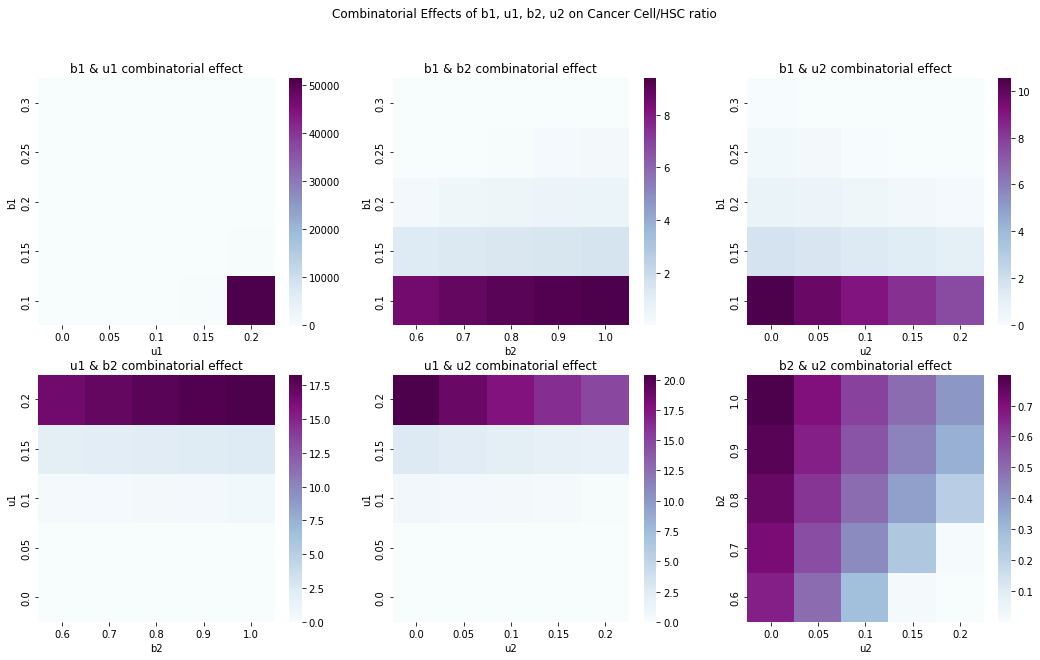

In [ ]:
# Plotting combination effects
#base paramdct {'b1':0.2, 'u1': 0.1, 'b2':0.8, 'u2':0.1}
b1_baseline = b1_levels[2]
u1_baseline = u1_levels[2]
b2_baseline = b2_levels[2]
u2_baseline = u2_levels[2]


fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Combinatorial Effects of b1, u1, b2, u2 on Cancer Cell/HSC ratio')

# b1 & u1 combinatorial effect
df_b1u1 = df.copy()
df_b1u1 = df_b1u1.loc[((df_b1u1['b2']==b2_baseline) & (df_b1u1['u2']==u2_baseline)),['b1','u1','cancer/HSC']]
pivot = df_b1u1.pivot('b1','u1','cancer/HSC')
_ =sns.heatmap(ax=axes[0, 0], data=pivot, cmap="BuPu")
_.invert_yaxis()
_.set_title('b1 & u1 combinatorial effect')

# b1 & b2 combinatorial effect
df_b1b2 = df.copy()
df_b1b2 = df_b1b2.loc[((df_b1b2['u1']==u1_baseline) & (df_b1b2['u2']==u2_baseline)),['b1','b2','cancer/HSC']]
pivot = df_b1b2.pivot('b1','b2','cancer/HSC')
_ =sns.heatmap(ax=axes[0, 1], data=pivot, cmap="BuPu")
_.invert_yaxis()
_.set_title('b1 & b2 combinatorial effect')

# b1 & u2 combinatorial effect
df_b1u2 = df.copy()
df_b1u2 = df_b1u2.loc[((df_b1u2['u1']==u1_baseline) & (df_b1u2['b2']==b2_baseline)),['b1','u2','cancer/HSC']]
pivot = df_b1u2.pivot('b1','u2','cancer/HSC')
_ =sns.heatmap(ax=axes[0, 2], data=pivot, cmap="BuPu")
_.invert_yaxis()
_.set_title('b1 & u2 combinatorial effect')

# u1 & b2 combinatorial effect
df_u1b2 = df.copy()
df_u1b2 = df_u1b2.loc[((df_u1b2['b1']==b1_baseline) & (df_u1b2['u2']==u2_baseline)),['u1','b2','cancer/HSC']]
pivot = df_u1b2.pivot('u1','b2','cancer/HSC')
_ =sns.heatmap(ax=axes[1, 0], data=pivot, cmap="BuPu")
_.invert_yaxis()
_.set_title('u1 & b2 combinatorial effect')

# u1 & u2 combinatorial effect
df_u1u2 = df.copy()
df_u1u2 = df_u1u2.loc[((df_u1u2['b1']==b1_baseline) & (df_u1u2['b2']==b2_baseline)),['u1','u2','cancer/HSC']]
pivot = df_u1u2.pivot('u1','u2','cancer/HSC')
_ =sns.heatmap(ax=axes[1, 1], data=pivot, cmap="BuPu")
_.invert_yaxis()
_.set_title('u1 & u2 combinatorial effect')

# b2 & u2 combinatorial effect
df_b2u2 = df.copy()
df_b2u2 = df_b2u2.loc[((df_b2u2['b1']==b1_baseline) & (df_b2u2['u1']==u1_baseline)),['b2','u2','cancer/HSC']]
pivot = df_b2u2.pivot('b2','u2','cancer/HSC')
_ =sns.heatmap(ax=axes[1, 2], data=pivot, cmap="BuPu")
_.invert_yaxis()
_.set_title('b2 & u2 combinatorial effect')
plt.show()

# Study Question 2
How does increasing the birth rate of cancer and increasing the death rate of HSCs effect cancer cell density?

# Computational Study #2

Text(0.5, 0.98, 'Increasing HSC death rate, cancer cell birth rate b2=0.8')

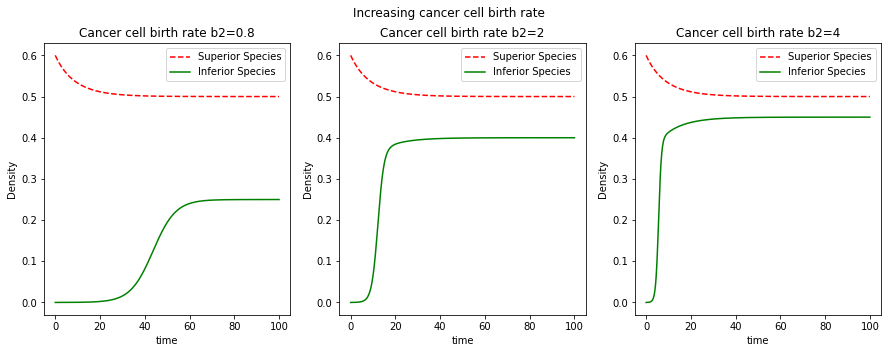

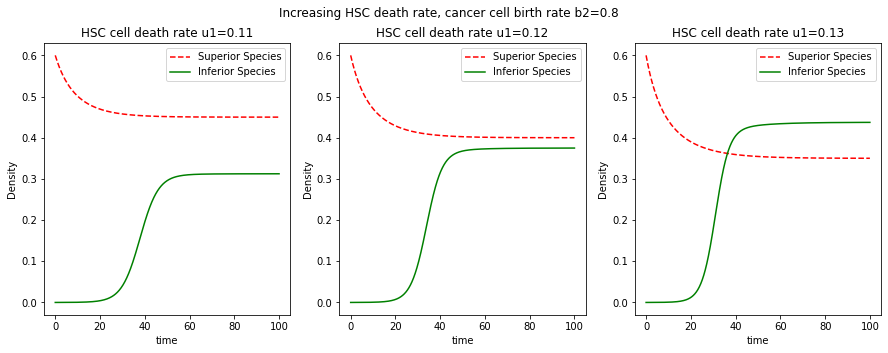

In [ ]:
# Modeling a more agressive cancer by increasing the birth rate of cancer cells

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, figsize=(15,5))
#base paramdct {'b1':0.2, 'u1': 0.1, 'b2':0.8, 'u2':0.1}
parameterDctList = [{'b1':0.2, 'u1': 0.1, 'b2':0.8, 'u2':0.1},
                    {'b1':0.2, 'u1': 0.1, 'b2':2, 'u2':0.1},
                    {'b1':0.2, 'u1': 0.1, 'b2':4, 'u2':0.1}]


for ax, parameterDct in zip((ax1, ax2, ax3), parameterDctList):
  MODEL_RR.resetAll()
  for key in parameterDct:
    MODEL_RR[key] = parameterDct[key]
  s = MODEL_RR.simulate(0, ENDTIME, NUMPOINT)

  ax.plot(s['time'], s['[H]'], "r--")
  ax.plot(s['time'], s['[T]'], "g")
  ax.legend(['Superior Species', 'Inferior Species'])
  ax.set_ylabel('Density')
  ax.set_xlabel('time')
  ax.set_title('Cancer cell birth rate b2='+str(parameterDct['b2']))
f.suptitle('Increasing cancer cell birth rate')

# Modeling a more agressive cancer by increasing the death rate of HSCs

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, figsize=(15,5))
#base paramdct {'b1':0.2, 'u1': 0.1, 'b2':0.8, 'u2':0.1}
parameterDctList = [{'b1':0.2, 'u1': 0.11, 'b2':0.8, 'u2':0.1},
                    {'b1':0.2, 'u1': 0.12, 'b2':0.8, 'u2':0.1},
                    {'b1':0.2, 'u1': 0.13, 'b2':0.8, 'u2':0.1}]


for ax, parameterDct in zip((ax1, ax2, ax3), parameterDctList):
  MODEL_RR.resetAll()
  for key in parameterDct:
    MODEL_RR[key] = parameterDct[key]
  s = MODEL_RR.simulate(0, ENDTIME, NUMPOINT)

  ax.plot(s['time'], s['[H]'], "r--")
  ax.plot(s['time'], s['[T]'], "g")
  ax.legend(['Superior Species', 'Inferior Species'])
  ax.set_ylabel('Density')
  ax.set_xlabel('time')
  ax.set_title('HSC cell death rate u1='+str(parameterDct['u1']))
f.suptitle('Increasing HSC death rate, cancer cell birth rate b2=0.8')

# Study Question 3
How does the removal of cancer cells (inferior species), such as in surgery, effect the outcome of cancer cell density?

# Computational Study #3
Performing Surgery

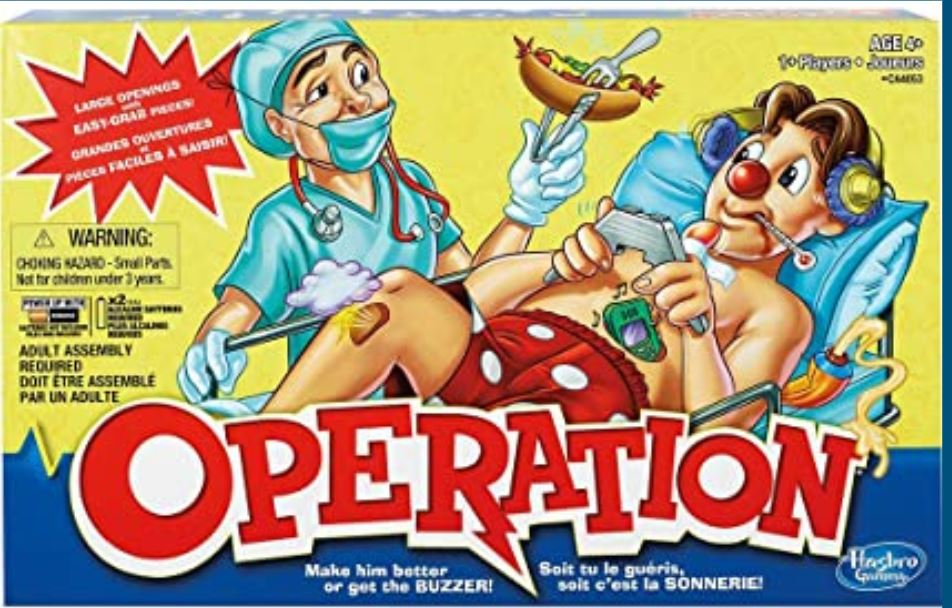

###Model String with event added

In [ ]:
# Adding a surgery event (removing % of tumor)

def exp_model(model_str, s=0.2, t=50):
  '''
  takes a percentage and substitutes it for an event

  Parameters
  ----------
  model_str - antimony model
  s - percentage of tumor to remove
  t - time to remove
  Returns
  -------
  new model_str
  '''
  model_str = model_str.replace('%s', str(1-s))
  model_str = model_str.replace('%t', str(t))
  return model_str

# tests
model_str = '''
// Created by libAntimony v2.12.0
function hg(b1, H)
  b1*H*(1 - H);
end

hg is "hg"

function tg(b2, T, H)
  b2*T*(1 - T - H);
end

tg is "tg"

function ti(b1, T, H)
  b1*T*H;
end

ti is "ti"


model *Chen2011_1___bone_marrow_invasion_absolute_model()

  // Compartments and Species:
  compartment bone_marrow;
  species H in bone_marrow, T in bone_marrow;

  // Reactions:
  HSC_growth:  => H; bone_marrow*hg(b1, H);
  HSC_death: H => ; bone_marrow*u1*H;
  Tumor_growth:  => T; bone_marrow*tg(b2, T, H);
  Tumor_death: T => ; bone_marrow*u2*T;
  Tumor_inhibition: T => ; bone_marrow*ti(b1, T, H);

  // Species initializations:
  H = 0.6;
  H has substance_per_volume;
  T = 0.0001;
  T has substance_per_volume;

  // Compartment initializations:
  bone_marrow = 1;
  bone_marrow has volume;

  // Variable initializations:
  b1 = 0.2;
  b1 has unit_0;
  u1 = 0.1;
  u1 has unit_0;
  b2 = 0.8;
  b2 has unit_0;
  u2 = 0.1;
  u2 has unit_0;

  at (time > %t): T = T*%s

  // Other declarations:
  const bone_marrow, b1, u1, b2, u2;

  // Unit definitions:
  unit length = metre;
  unit area = metre^2;
  unit volume = 1e-3 litre;
  unit time_unit = time_unit;
  unit substance = 1e-3 mole;
  unit unit_0 = 1 / dimensionless^-0;
  unit extent = substance;
  unit substance_per_volume = 1e-3 mole / 1e-3 litre;

  // Display Names:
  time_unit is "time";
  unit_0 is "1";
  bone_marrow is "bone marrow";
  HSC_growth is "HSC growth";
  HSC_death is "HSC death";
  Tumor_growth is "Tumor growth";
  Tumor_death is "Tumor death";
  Tumor_inhibition is "Tumor inhibition";

  // CV terms:
  bone_marrow identity "http://identifiers.org/bto/BTO:0000141"
  bone_marrow hypernym "http://identifiers.org/ncit/C94498"
  H hypernym "http://identifiers.org/cl/CL:0000037"
  T hypernym "http://identifiers.org/cl/CL:0001064"
  b1 hypernym "http://identifiers.org/sbo/SBO:0000610"
  u1 hypernym "http://identifiers.org/ncit/C25636"
  b2 hypernym "http://identifiers.org/sbo/SBO:0000610"
  u2 hypernym "http://identifiers.org/ncit/C25636"
  HSC_growth hypernym "http://identifiers.org/sbo/SBO:0000393"
  HSC_growth hypernym "http://identifiers.org/go/GO:0008283"
  HSC_death hypernym "http://identifiers.org/go/GO:0008219"
  HSC_death hypernym "http://identifiers.org/sbo/SBO:0000179"
  Tumor_growth hypernym "http://identifiers.org/sbo/SBO:0000393"
  Tumor_growth hypernym "http://identifiers.org/go/GO:0008283"
  Tumor_death hypernym "http://identifiers.org/sbo/SBO:0000179"
  Tumor_death hypernym "http://identifiers.org/go/GO:0008219"
  Tumor_inhibition hypernym "http://identifiers.org/sbo/SBO:0000179"
  Tumor_inhibition hypernym "http://identifiers.org/go/GO:0008219"
end

Chen2011_1___bone_marrow_invasion_absolute_model is "Chen2011/1 - bone marrow invasion absolute model"

Chen2011_1___bone_marrow_invasion_absolute_model model_entity_is "http://identifiers.org/biomodels.db/MODEL1908130002",
                                                                 "http://identifiers.org/biomodels.db/BIOMD0000000793"
Chen2011_1___bone_marrow_invasion_absolute_model container "http://identifiers.org/bto/BTO:0000141"
Chen2011_1___bone_marrow_invasion_absolute_model property "http://identifiers.org/mamo/MAMO_0000046"
Chen2011_1___bone_marrow_invasion_absolute_model property "http://identifiers.org/ncit/C20625"
Chen2011_1___bone_marrow_invasion_absolute_model taxon "http://identifiers.org/taxonomy/9606"
Chen2011_1___bone_marrow_invasion_absolute_model description "http://identifiers.org/pubmed/21967667"
'''
test_ANT = exp_model(model_str, t=0, s=0)
test_RR = te.loada(test_ANT)
test_RR.simulate(0, 100, 1200)
assert(test_RR.simulate(0, 100, 1200).all()==MODEL_ARR.all())

How does 'performing surgery', eg. removing a percentage of the tumor at different times effect end point cancer cell density? 

Text(0.5, 0.98, 'Removing % of tumor at halfway point')

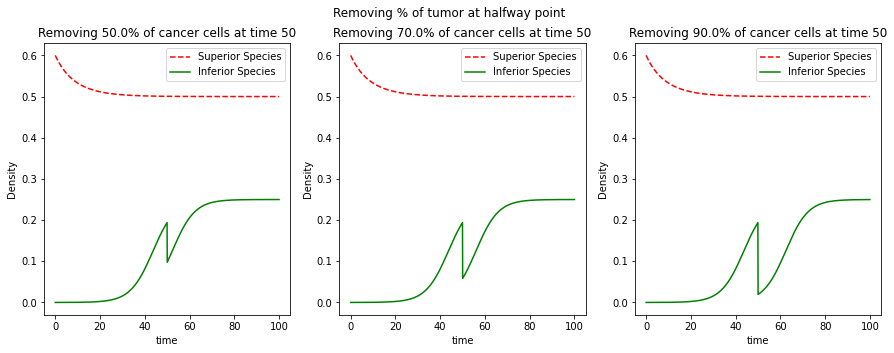

In [ ]:
# try removing % of tumor at halfway point

s_tlist = [(0.5, 50), (0.7, 50), (0.9, 50)]
m_list = []
for st in s_tlist:
  model = exp_model(model_str, s=st[0], t=st[1])
  a=te.loada(model)
  m=a.simulate(0, ENDTIME, NUMPOINT)

  m_list.append(m)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, figsize=(15,5))
ax_list = [ax1, ax2, ax3]
for ax, m, st in zip(ax_list,m_list,s_tlist):
  ax.plot(m['time'], m['[H]'], "r--")
  ax.plot(m['time'], m['[T]'], "g")
  ax.legend(['Superior Species', 'Inferior Species'])
  ax.set_ylabel('Density')
  ax.set_xlabel('time')
  ax.set_title('Removing '+str(st[0]*100)+'% of cancer cells at time '+str(st[1]))

f.suptitle('Removing % of tumor at halfway point')

Text(0.5, 0.98, 'Removing 90% of tumor at different time points')

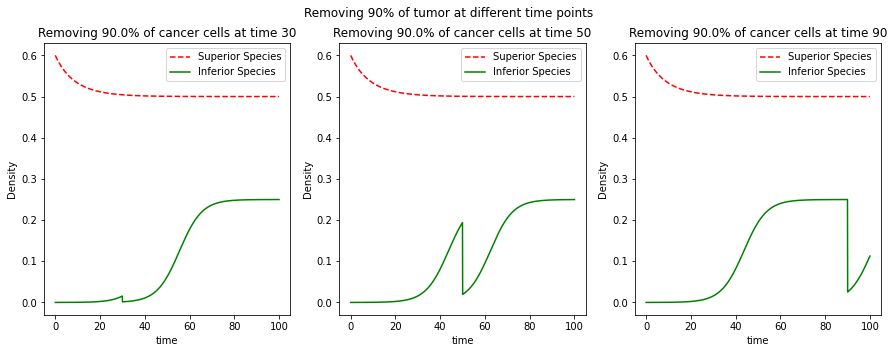

In [ ]:
# try removing 50% of tumor at different points

s_tlist = [(0.9, 30), (0.9, 50), (0.9, 90)]
m_list = []
for st in s_tlist:
  model = exp_model(model_str, s=st[0], t=st[1])
  a=te.loada(model)
  m=a.simulate(0, ENDTIME, NUMPOINT)

  m_list.append(m)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, figsize=(15,5))
ax_list = [ax1, ax2, ax3]
for ax, m, st in zip(ax_list,m_list,s_tlist):
  ax.plot(m['time'], m['[H]'], "r--")
  ax.plot(m['time'], m['[T]'], "g")
  ax.legend(['Superior Species', 'Inferior Species'])
  ax.set_ylabel('Density')
  ax.set_xlabel('time')
  ax.set_title('Removing '+str(st[0]*100)+'% of cancer cells at time '+str(st[1]))


f.suptitle('Removing 90% of tumor at different time points')

# Discussion of Results

My new study question sought to find the combinatorial effects of b1, u1, b2, u2 on the ratio of cancer to HSCs. I had the initial values of my model as the baseline and had 5 levels total tested for each parameter, increasing and decreasing compared to baseline. 

I found overall that minimizing the birth rate of HSCs and the death rate of cancer cells, while maximizing the death rate of HSCs and the birth rate of cancer cells had the greatest positive effect on Cancer Cell/HSC ratio. 

It seems out of all the possible variable combinations b1 and u2 had the largest combinatorial relationship. Eg. largest effect when b1 is large and u2 is small

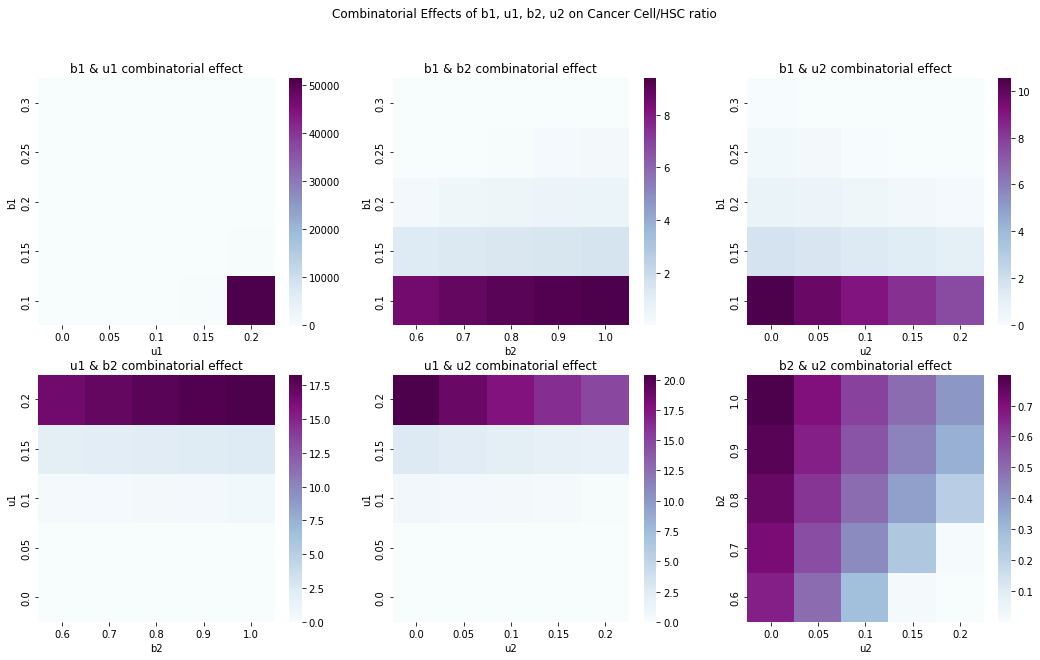

I also sought to find the effects of increasing cancer cell birth rate. I found that increasing the birth rate did increase the cancer cell ratior but up to a limit. Which makes sense contexutally becuase cancer as an inferior species can only grow so large until it runs out of space. 

However, when I increased the death rate of HSC, even with the least agressive cancer (b2=0.8), cancer cells were able to overtake HSCs. Likening to our previous conclusion that cancer cells will grow when given space



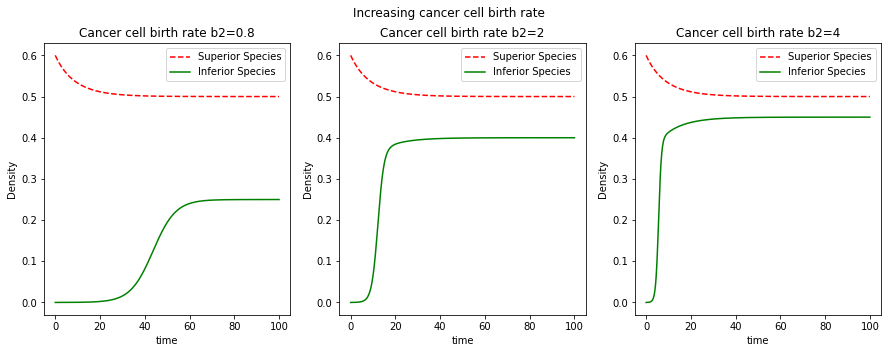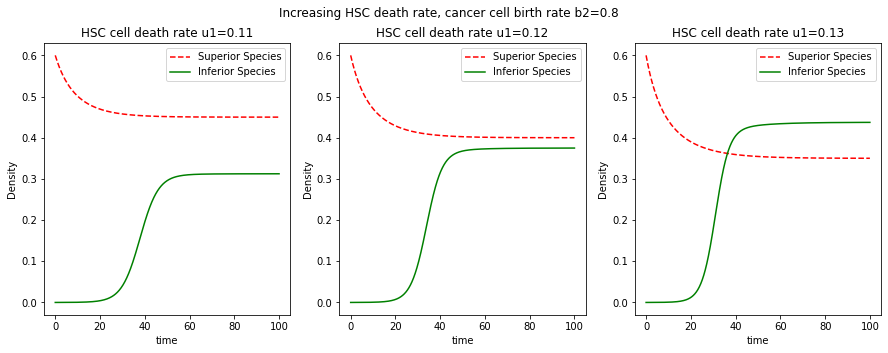

My 3rd study question sought to find the effects of "surgery", aka removing x% of the cancer cells at a given time. The parameters are still set to baseline here with b2=0.8 agressive cancer. My first study found that removing any % of cancer at the halfway point will still result in full remission. 

In addition, removing the cancer at any time point will still result in full remission. Likening to the reality of tumor removal, where agressive solid tumors will have to be removed multiple times if not removed completley. 

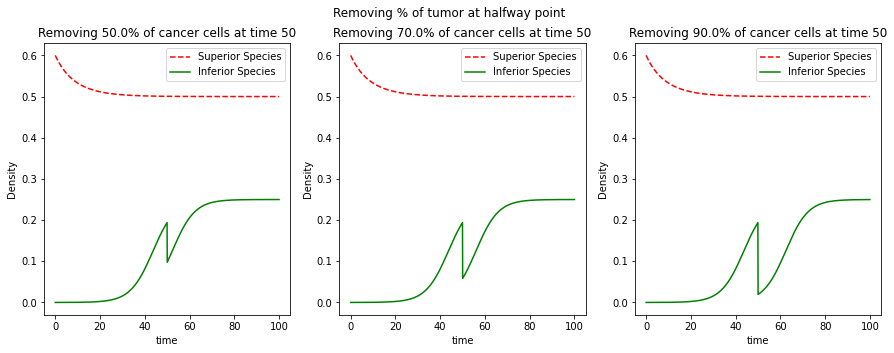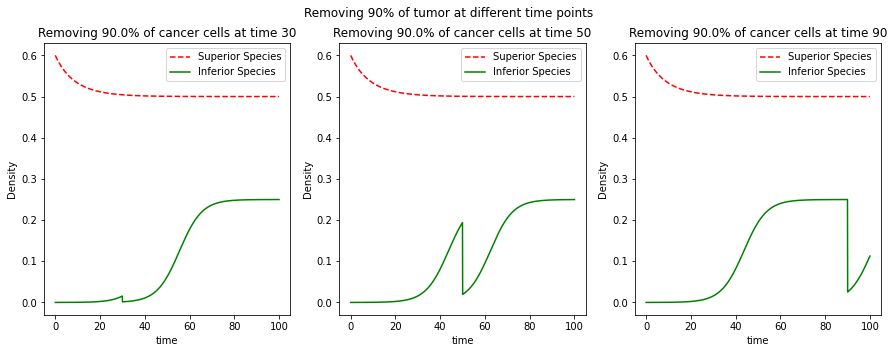

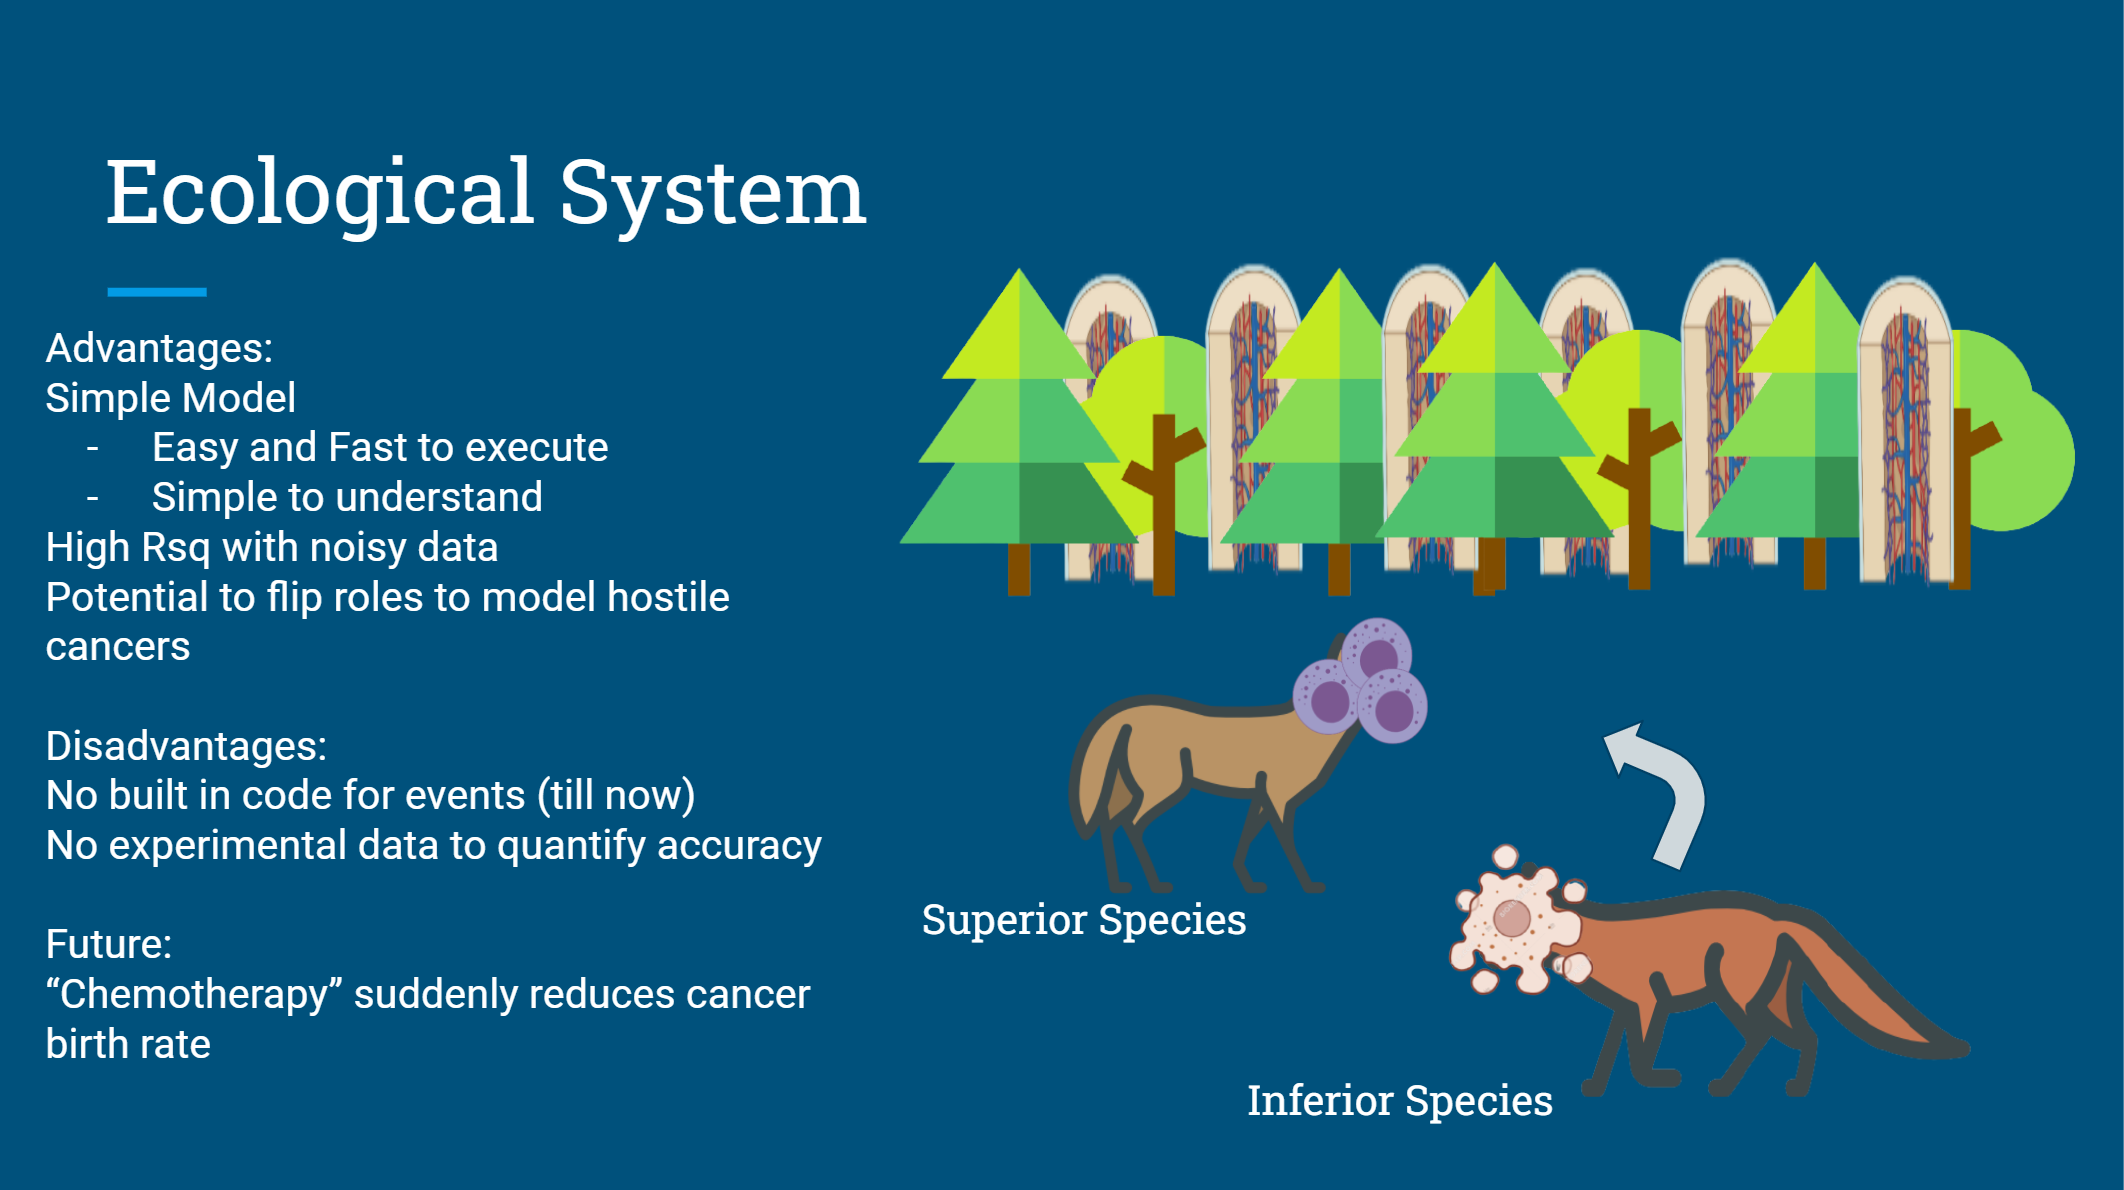